This project is for my Honors College senior project at Grand Valley State University. The project allows for independent research within our major field of study. For this project, I wanted to explore machine learning. I wanted to create a model that was related to sports. I decided on attempting to predict baseball player salary using various statistics.

The first step in this process was to find a dataset with sufficient data. I am using [Lahman's Database](http://www.seanlahman.com/baseball-archive/statistics), which contains historical baseball statistics as well as salary data. I downloaded the .csv version of this dataset. I can import this data into my code for preprocessing.

First, I import all necessary libraries and create arrays to store the data.

In [1]:
import csv
import pandas as pd
import math
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics

#holds data from csv files
batters =  []
people = []
salaries = []
trainingList = []

Next, I import the data from the .csv files. The files I will import from are People.csv, Salaries.csv, and NewBatting.csv. These tables are related by a key playerID. People.csv contains information about players such as name and age.

In [2]:
with open("../data/core/People.csv") as csvDataFile1:
    csvReader1 = csv.reader(csvDataFile1)
    for row1 in csvReader1:
        #id, birth year, month, day, first name, last name
        people.append([row1[0], row1[1], row1[2], row1[3], row1[13], row1[14]])

The next file is Salaries.csv, which contains salary information for each player for each season.

In [3]:
with open("../data/core/Salaries.csv") as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        salaries.append([row[0], row[1], row[2], row[3], row[4]])

The last file is NewBatting.csv. This is modified version of the Batting.csv file from the Lahman database. This file contains batting stats from 1985 to 2016, while the original contains batting stats dating back to 1871. I removed this older data to match up with the salary data which is also from 1985 to 2016. Additionally, this helps reduce execution time. Additionally, I calculate some other statistics that aren't included in the database such as batting average, on base percentage, and slugging percentage.

In [4]:
with open("../data/core/NewBatting.csv") as csvDataFile2:
    csvReader2 = csv.reader(csvDataFile2)
    for row in csvReader2:
        avg = 0.0
        obp = 0.0
        slg = 0.0

        if float(row[6]) != 0.0:
            avg = float(row[8]) / float(row[6])
            slg = (float(row[8]) + (2 * float(row[9])) + (3 * float(row[10])) + (4 * float(row[11]))) / float(row[6])

        if (float(row[6]) + float(row[15]) + float(row[17]) + float(row[18]) + float(row[20])) != 0.0:
            obp = (float(row[8]) + float(row[15]) + float(row[17]) + float(row[18])) / (float(row[6]) + float(row[15]) + float(row[17]) + float(row[18]) + float(row[20]))
        
        batters.append([row[0], row[1], row[3], str(avg), str(obp), str(slg), row[11], row[13]])

The following code joins the tables together based on the player ID key. Additionally, I adjust salaries for inflation and split the player salaries into different categories. The joined data is added to a list, which is then converted to a pandas dataframe.

In [5]:
for player in salaries:
    for batter in batters: 
        if player[3] == batter[0] and player[0] == batter[1] and batter[2] == player[1]:
            if len(player) <= 6:
                player.append(batter[3])
                player.append(batter[4])
                player.append(batter[5])
                player.append(batter[6])
                player.append(batter[7])

                # Adjust salary for inflation
                time = 2017 - int(player[0])
                temp = math.pow(1.03, time)
                adjustedSalary = int(player[4]) * temp
                player.append(adjustedSalary)

                # Categorize the player salary
                if adjustedSalary < 1000000:
                    player.append(1) # minimum

                elif adjustedSalary < 5000000 and adjustedSalary >= 1000000:
                    player.append(2) # very low 

                elif adjustedSalary < 10000000 and adjustedSalary >= 5000000:
                    player.append(3) # low
                
                elif adjustedSalary < 15000000 and adjustedSalary >= 10000000:
                    player.append(4) # average

                elif adjustedSalary < 20000000 and adjustedSalary >= 15000000:
                    player.append(5) # high

                elif adjustedSalary < 25000000 and adjustedSalary >= 20000000:
                    player.append(6) # very high

                elif adjustedSalary < 300000000 and adjustedSalary >= 25000000:
                    player.append(7) # mvp

                else:
                    player.append(-1) # no data

    for person in people:
        if player[3] == person[0]:
            # Calculate player age for a given season
            age = int(player[0]) - int(person[1])
            player.append(age)

    trainingList.append(player)
    
trainingDF = pd.DataFrame(trainingList, columns=['Year', 'Team', 'League', 'Player ID', 'Salary', 'Average', 'On Base Percentage', 'Slugging Percentage', 'Home Runs', 'Stolen Bases', 'Adjusted Salary', 'Category', 'Age'])
# Fill in NaN values
trainingDF.fillna(0, inplace=True)

The next block of code trains the model and tests it. I can change settings in here to include different variables to test. For the first test, I only test with batting average.

Accuracy: 0.5150597850764341


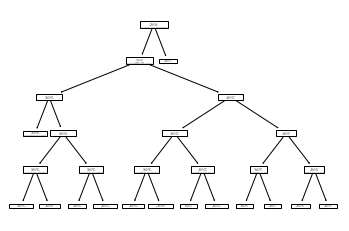

In [6]:
# https://www.datacamp.com/community/tutorials/decision-tree-classification-python
# https://scikit-learn.org/stable/modules/tree.html#classification

# This line is where I change which features to test on
features = ['Average']
x = trainingDF[features]
# Predicting the salary classification
y = trainingDF.Category

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(x_train,y_train)
tree.plot_tree(clf)
y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

The accuracy for predicting salary with just batting average isn't so great, because there are many other factors that contribute to a player's skill. A position player might have a low average but be better at hitting home runs, fielding, or baserunning, and therefore earn a higher salary. Additionally, batting average has fallen out of flavor for some baseball statisticians because of its flaws. Next I'll try some other individual statistics to see the accuracy.

Accuracy: 0.47888602996821555


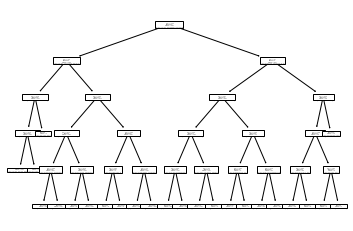

In [7]:
features = ['On Base Percentage']
x = trainingDF[features]
y = trainingDF.Category

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(x_train,y_train)
tree.plot_tree(clf)
y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.477977902224913


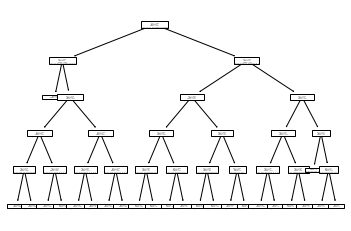

In [8]:
features = ['Slugging Percentage']
x = trainingDF[features]
y = trainingDF.Category

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(x_train,y_train)
tree.plot_tree(clf)
y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.49129710912668384


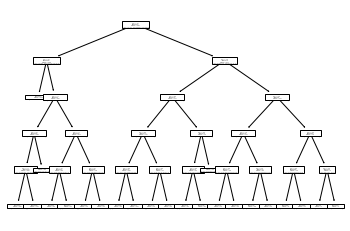

In [9]:
features = ['Home Runs']
x = trainingDF[features]
y = trainingDF.Category

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(x_train,y_train)
tree.plot_tree(clf)
y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4787346753443318


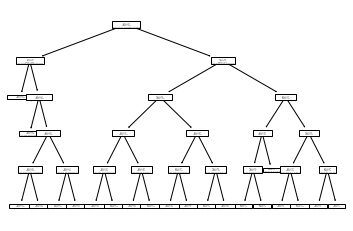

In [10]:
features = ['Stolen Bases']
x = trainingDF[features]
y = trainingDF.Category

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(x_train,y_train)
tree.plot_tree(clf)
y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

None of the statistics are very good individually. Before I combine them, I want to check if age has any impact on the accuracy. Baseball contracts are structured in a way where star players are likely underpaid in their first few seasons relative to their actual value, and overpaid in their later seasons when they start to decline. The model's accuracy will likely increase when I include age with each of these statistics.

Accuracy: 0.5987588920841531


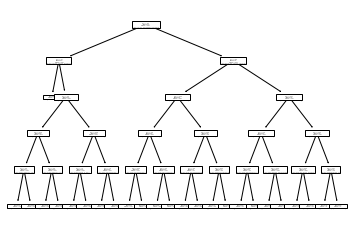

In [11]:
features = ['Average', 'Age']
x = trainingDF[features]
y = trainingDF.Category

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(x_train,y_train)
tree.plot_tree(clf)
y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5986075374602694


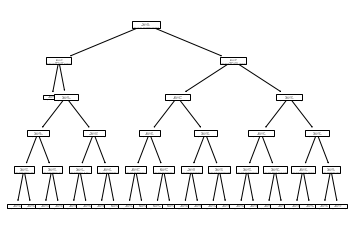

In [12]:
features = ['On Base Percentage', 'Age']
x = trainingDF[features]
y = trainingDF.Category

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(x_train,y_train)
tree.plot_tree(clf)
y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6020886938095958


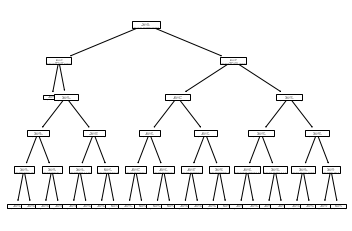

In [13]:
features = ['Slugging Percentage', 'Age']
x = trainingDF[features]
y = trainingDF.Category

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(x_train,y_train)
tree.plot_tree(clf)
y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6095050703799001


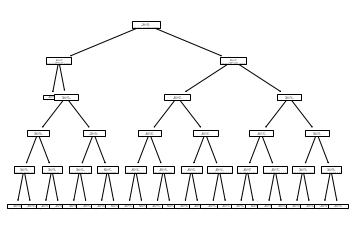

In [14]:
features = ['Home Runs', 'Age']
x = trainingDF[features]
y = trainingDF.Category

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(x_train,y_train)
tree.plot_tree(clf)
y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6016346299379446


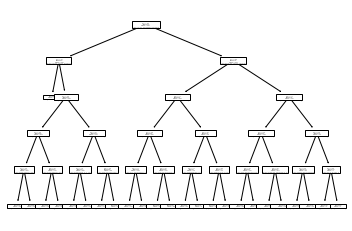

In [15]:
features = ['Stolen Bases', 'Age']
x = trainingDF[features]
y = trainingDF.Category

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(x_train,y_train)
tree.plot_tree(clf)
y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

The accuracy did increase by about 10% when age was included. This makes sense given that generally speaking, younger players are underpaid and older players are overpaid. Therefore, having age allows the model to be more accurate in predicting salary categorization. 

Finally, let's put all of these statistics in the model and see if the accuracy is any better. I am expecting a slight increase in accuracy.

Accuracy: 0.6107159073709701


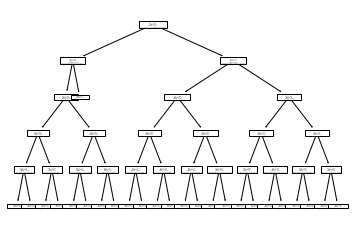

In [16]:
features = ['Average', 'On Base Percentage', 'Slugging Percentage', 'Home Runs', 'Stolen Bases', 'Age']
x = trainingDF[features]
y = trainingDF.Category

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(x_train,y_train)
tree.plot_tree(clf)
y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

This actually had a very slight increase in accuracy. I was expecting more of an increase though. This shows that these statistics are not amazing at predicting salary.

There are some easy to see flaws with my model so far. I should use more rate stats like HR/AB instead of flat HR. Additionally, I could use more advanced stats like Wins Above Replacement (WAR), Weighted Runs Created + (wRC+), or Weighted On Base Average (wOBA) which aim to provide a more complete look at a player's strengths. I did not use these because the database I used did not have these stats available. I also did not include enough baserunning or fielding stats. This might improve my accuracy if I did that. Another possible reason for inaccuracy is pitcher hitting statistics. Pitchers are notoriously bad at hitting, but their salary might still be much higher due to their pitching skills. It would improve the accuracy for hitters if I excluded hitting statistics from pitchers.

Some things I might try to improve this model are predicting pitcher salary to see how that differs from hitters, using more advanced baseball statistics, and trying to include a more well rounded set of statistics as features that include all parts of the game.